In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

import tifffile
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)


In [2]:
wavelengths = [647, 561, 488]  # nm
color647 = 'C3'
color561 = 'C2'
color488 = 'C0'
laser_colors = [color647, color561, color488]

In [3]:
def gaussian_2D(xy, amplitude, offset, mu_x, mu_y, sigma):
    x, y = xy
    res = amplitude * np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2)) + offset
    return np.ravel(res)

In [4]:
def read_img(path: str) -> np.ndarray:
    imdata = tifffile.imread(path)
    pix_min = np.min(imdata, axis=(1,2))
    pix_max = np.max(imdata, axis=(1,2))
    normalized_imdata = (imdata - pix_min[:, np.newaxis, np.newaxis]) / (pix_max - pix_min)[:, np.newaxis, np.newaxis]
    return normalized_imdata

In [5]:
def do_fit(selection):
    XX = np.arange(selection.shape[0])
    YY = np.arange(selection.shape[1])
    XY = np.meshgrid(XX, YY)
    popt, pcov = sc.optimize.curve_fit(
        gaussian_2D,
        XY, selection.flatten(),
        p0=(1, 0, selection.shape[0] / 2, selection.shape[1] / 2, 1),
        bounds=(0, np.inf)
    )
    return popt, pcov

In [6]:
imdata_647nm = read_img('../data/beads/Acquisition-1/ROI.tif')
imdata_561nm = read_img('../data/beads/Acquisition-2/ROI.tif')
imdata_488nm = read_img('../data/beads/Acquisition-3/ROI.tif')
all_imdata = [imdata_647nm, imdata_561nm, imdata_488nm]

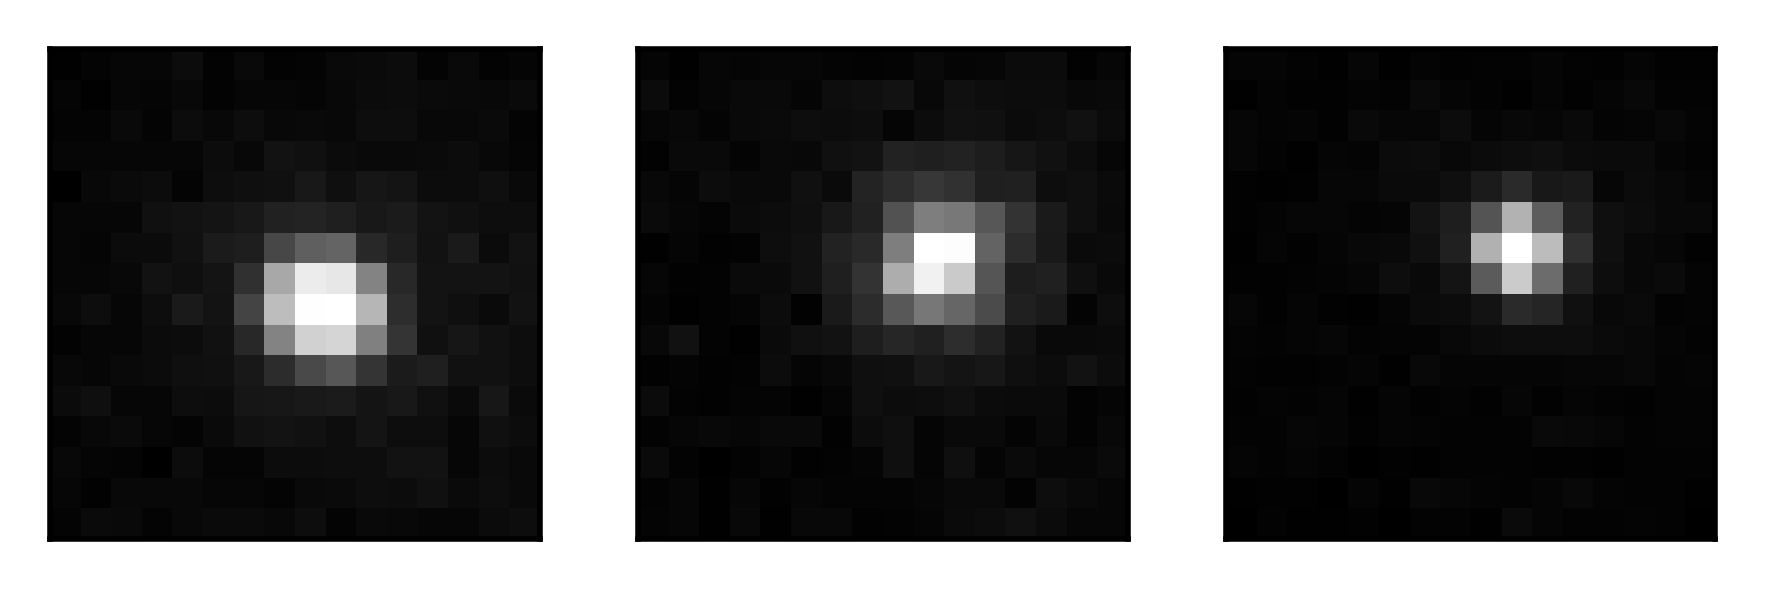

In [7]:
with mpl.rc_context():
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['xtick.bottom'] = False
    mpl.rcParams['xtick.labelbottom'] = False
    mpl.rcParams['ytick.left'] = False
    mpl.rcParams['ytick.labelleft'] = False
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (9*INCH_PER_CM, 3*INCH_PER_CM) 
    mpl.rcParams["figure.subplot.left"]   = 0.03
    mpl.rcParams['figure.subplot.right']  = 0.97
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.03
        

    bead_sel = [slice(138, 154), slice(208, 224)]
    fig, ax = plt.subplots(ncols=3, dpi=500)
    for i in range(3):
        ax[i].imshow(all_imdata[i][0, *bead_sel], cmap=plt.get_cmap('Greys_r'), rasterized=True)
        ax[i].grid(False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.savefig("../figures/beads_drifting.pdf")

In [8]:
mu_xs = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
mu_ys = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
sigmas = [np.zeros(imdata.shape[0]) for imdata in all_imdata]

for i, (wavelength, imdata) in enumerate(zip(wavelengths, all_imdata)):
    for j, layer in enumerate(imdata):
        popt, pcov = do_fit(layer[*bead_sel])
        mu_xs[i][j] = popt[2]
        mu_ys[i][j] = popt[3]
        sigmas[i][j] = popt[4]

## Maybe try airy disk?

In [9]:
def airy_disk(xy, amplitude, B, center_x, center_y):
    x, y = xy
    r = np.sqrt((x-center_x)**2 + (y-center_y)**2)
    # X = 2 * np.pi * r * NA / wavelength * B
    X = r * B
    
    res = np.ones(X.shape) * amplitude
    nonzero = X != 0
    res[nonzero] = amplitude * (2 * sc.special.j1(X[nonzero]) / X[nonzero])**2
    return np.ravel(res)

In [10]:
def do_fit_airy(selection):
    XX = np.arange(selection.shape[0])
    YY = np.arange(selection.shape[1])
    XY = np.meshgrid(XX, YY)
    fitfunc = lambda xy, A, B, cx, cy: airy_disk(xy, A, B, cx, cy)
    popt, pcov = sc.optimize.curve_fit(
        fitfunc,
        XY, selection.ravel(),
        p0=(1, 0.1, selection.shape[0] / 2, selection.shape[1] / 2),
        bounds=((0, 0, 0, 0), (np.inf, np.inf, selection.shape[0], selection.shape[1]))
    )
    return popt, pcov

In [11]:
mu_xs_airy = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
mu_ys_airy = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
sigmas_airy = [np.zeros(imdata.shape[0]) for imdata in all_imdata]

for i, (wavelength, imdata) in enumerate(zip(wavelengths, all_imdata)):
    for j, layer in enumerate(imdata):
        popt, pcov = do_fit_airy(layer[*bead_sel])
        mu_xs_airy[i][j] = popt[2]
        mu_ys_airy[i][j] = popt[3]
        sigmas_airy[i][j] = 3.8317 / popt[1]

In [12]:
# Results for position are very good
(mu_xs_airy[0].mean(), mu_xs[0].mean()), (mu_ys_airy[0].mean(), mu_ys[0].mean())

((np.float64(8.438415899698215), np.float64(8.430354680041042)),
 (np.float64(7.920393405240697), np.float64(7.9157773306841115)))

In [13]:
# Resolution on the other hand...
(sigmas_airy[0].mean(), sigmas[0].mean())

(np.float64(4.087089037112765), np.float64(1.258717562175051))

[0.44084887 0.92235059 8.45204302 7.89479396]
448.6619325829691


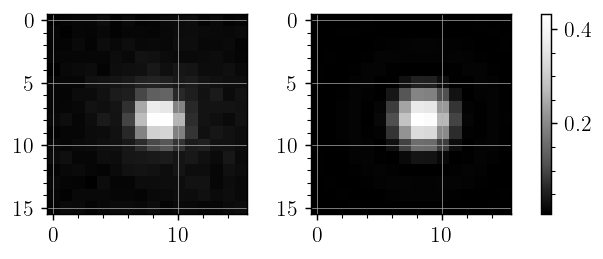

In [14]:
# Testing grounds
selection = imdata_647nm[0, *bead_sel]
popt, pcov = do_fit_airy(selection)
print(popt)
# The reslolution estimation is absolute shit
delta_r = 3.8317 / popt[1] * NM_PER_PX
print(delta_r)

fig, ax = plt.subplots(figsize=(6, 2), ncols=2)

im1 = ax[0].imshow(selection, cmap='Greys_r')
XX = np.arange(selection.shape[0])
YY = np.arange(selection.shape[1])
XY = np.meshgrid(XX, YY)
im2 = ax[1].imshow(airy_disk(XY, *popt).reshape(XX.shape[0], -1), cmap='Greys_r')

fig.colorbar(im1, ax=ax.tolist())
plt.show()

### Show the stuff

In [15]:
p = plt.rcParams
p['savefig.bbox'] = 'standard'
p["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
p["figure.subplot.left"]   = 0.17
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.97
p['figure.subplot.bottom'] = 0.18

In [16]:
plt.hist(sigmas[0], alpha=0.8, color=color647,
        label=fr"{wavelengths[0]} nm")
plt.hist(sigmas[1], alpha=0.8, color=color561,
        label=fr"{wavelengths[1]} nm")
plt.hist(sigmas[2], alpha=0.8, color=color488,
        label=fr"{wavelengths[2]} nm")
plt.xlabel(r"$\sigma$ [px]")
plt.ylabel(r"Count")

plt.legend(loc='lower left', bbox_to_anchor=(0.15, 0.6))
plt.savefig("../figures/comparison_sigma.pdf")

### x and y

In [17]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, label, color):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.scatter(x, y, marker='.', s=2, label=label, color=color)

    ax_histx.hist(x, color=color)
    ax_histy.hist(y, orientation='horizontal', color=color)


In [18]:
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.2
p['figure.subplot.right']  = 1
p['figure.subplot.top']    = 1.2
p['figure.subplot.bottom'] = 0.18

fig = plt.figure()

ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(mu_xs[0], mu_ys[0], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[0]} nm", color=color647)
scatter_hist(mu_xs[1], mu_ys[1], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[1]} nm", color=color561)
scatter_hist(mu_xs[2], mu_ys[2], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[2]} nm", color=color488)

ax.set_xlabel(r"$\mu_x$ [px]")
ax.set_ylabel(r"$\mu_y$ [px]")
ax_histx.set_ylabel('Count')
ax_histy.set_xlabel('Count')

# blegh
plt.axis('square')
xlims = ax.get_xlim()
ax.set_xlim(xlims[0] - 0.5, xlims[1] - 0.5)

plt.legend(markerscale=4, handlelength=0.4, scatteryoffsets=[0.5])
plt.savefig("../figures/comparison_mu.pdf")

[25.06577677 35.11766592 26.14819431]
2.467156031648141 3.3628993867020402 9.867255695283756
3.7232845466099302 3.4551581787133054 9.866080964510427
3.278345794501438 3.830089311837524 9.863606542414058


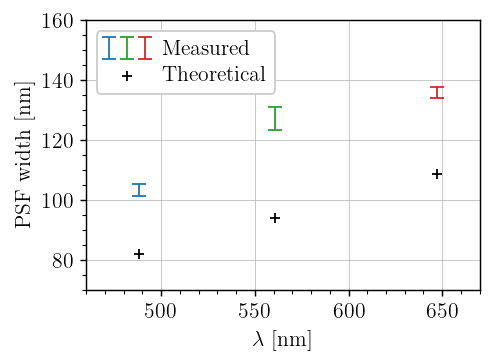

In [ ]:
NM_PER_PX = 108  # nm
psf_widths = unp.uarray(
    list(map(lambda s: np.mean(s * NM_PER_PX), sigmas)),
    list(map(lambda s: np.std(s * NM_PER_PX), sigmas))
)

plt.figure(figsize=(3.95, 2.96))
plt.xlim(460, 670)
plt.ylim(70, 160)
ax = plt.gca()
errbars = []
for i in [0,1,2]:
    errbars.append(plt.errorbar(wavelengths[i], nom_vals(psf_widths[i]), yerr=std_devs(psf_widths[i]), 
                              ls='', label='Measured', color=laser_colors[i]))
theoretical = np.array(list(map(lambda l: 0.21 * l / NUMERICAL_APERTURE, wavelengths)))
sc = plt.scatter(wavelengths, theoretical, color='k', label='Theoretical')
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'PSF width [nm]')

# Error on theoretical
print(np.abs(nom_vals(psf_widths) - theoretical)/theoretical * 100)
# Localisation precision
for x, y, s in zip(mu_xs, mu_ys, sigmas):
    print(
        np.std(x * NM_PER_PX), np.std(y * NM_PER_PX),
    )

l = ax.legend([(errbars[2], errbars[1], errbars[0]), sc], ['Measured', 'Theoretical'],
               handler_map={tuple: HandlerTuple(ndivide=3, pad=0.5)}, handlelength=2)
# uhhhh stinky
plt.tight_layout()

plt.savefig("../figures/comparison_PSF.pdf")
plt.show()

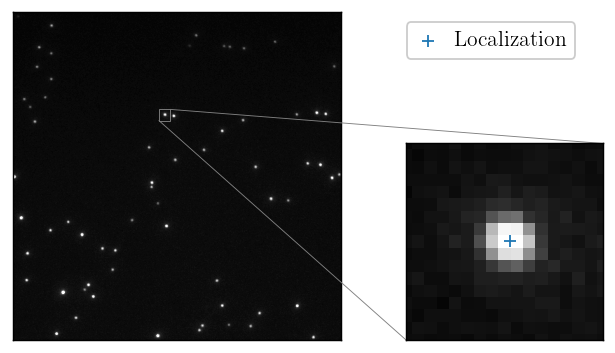

In [20]:
with mpl.rc_context():
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['xtick.bottom'] = False
    mpl.rcParams['xtick.labelbottom'] = False
    mpl.rcParams['ytick.left'] = False
    mpl.rcParams['ytick.labelleft'] = False

    mpl.rcParams['savefig.bbox'] = 'tight'
    # fig, ax = plt.subplots(1,1, figsize=(14*INCH_PER_CM, 7*INCH_PER_CM))
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])

    mu_xs_647nm = mu_xs[0]
    mu_ys_647nm = mu_ys[0]

    plt.imshow(imdata_647nm[0,:,:], cmap='Greys_r',
            vmax=0.4)

    axins = ax.inset_axes([1,0,1,0.6], xlim=(bead_sel[1].start,bead_sel[1].stop), ylim=(bead_sel[0].start, bead_sel[0].stop), alpha=0.5)
    rect, connection_lines = ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=1, lw=0.5)
    plt.setp(connection_lines, lw=0.5)
    # connection_lines[0].set_visible(True)
    # connection_lines[1].set_visible(True)
    # connection_lines[2].set_visible(True)
    # connection_lines[3].set_visible(True)
    axins.set_xticks([])
    axins.set_yticks([])

    axins.invert_yaxis()
    axins.imshow(imdata_647nm[0], cmap=plt.get_cmap('Greys_r'),
                vmax=0.4)
    axins.scatter(np.mean(mu_xs_647nm+bead_sel[1].start), np.mean(mu_ys_647nm+bead_sel[0].start), marker='+', s=40,
                label='Localization')

    handles, labels = axins.get_legend_handles_labels()

    fig.legend(handles=handles, labels=labels, bbox_to_anchor=(1.6, 1.15))
    plt.savefig("../figures/beads_inset_zoom.pdf")
    plt.show()